### Deliverables
For a project, you repository/folder should contain the following:

- README.md with
    - Description of the problem
    - Instructions on how to run the project
- Data
    -You should either commit the dataset you used or have clear instructions how to download the dataset
- Notebook (suggested name - notebook.ipynb) with
    - Data preparation and data cleaning
    - EDA, feature importance analysis
    - Model selection process and parameter tuning
- Script train.py (suggested name)
    - Training the final model
    - Saving it to a file (e.g. pickle) or saving it with specialized software (BentoML)
- Script predict.py (suggested name)
    - Loading the model
    - Serving it via a web service (with Flask or specialized software - BentoML, KServe, etc)
- Files with dependencies
    - Pipenv and Pipenv.lock if you use Pipenv
    - or equivalents: conda environment file, requirements.txt or pyproject.toml
- Dockerfile for running the service
- Deployment
    - URL to the service you deployed or
    - Video or image of how you interact with the deployed service

## Midterm project
This workbook contain the analysis for the midterm project

It contain EDA, model selection and saving the scripts

### Load the needed libraries for the analysis

In [1]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_curve

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Loading the data and examine it

Below are the basic description of the columns
- Feature	Description
- customer_id	Unique identifier for each customer
- credit_score	Credit score of the customer
- country	Customer’s country of residence
- gender	Customer’s gender
- age	Customer’s age
- tenure	Number of years the customer has been with the bank
- balance	Account balance of the customer
- products_number	Number of products used by the customer
- credit_card	Whether the customer has a credit card (1: Yes, 0: No)
- active_member	Whether the customer is an active member (1: Yes, 0: No)
- estimated_salary	Estimated annual salary of the customer
- churn	Target variable indicating if the customer churned (1: Yes, 0: No)

In [2]:
## https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset/data?select=Bank+Customer+Churn+Prediction.csv
df = pd.read_csv("bank_churn_data.csv")

In [3]:
## Examine the first few row to the strucure of the data
df.head().T

,0,1,2,3,4
customer_id,15634602,15647311,15619304,15701354,15737888
credit_score,619,608,502,699,850
country,France,Spain,France,France,Spain
gender,Female,Female,Female,Female,Female
age,42,41,42,39,43
tenure,2,1,8,1,2
balance,0.0,83807.86,159660.8,0.0,125510.82
products_number,1,1,3,2,1
credit_card,1,0,1,0,1
active_member,1,1,0,0,1


In [4]:
## Check the data types. Note some  `credit_card`, `active_member` are indicated as int
## but are actually logical values
df.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

In [5]:
## Use describe to explore the data desctribution
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
## Drop customer ID
del df['customer_id']

In [7]:
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Set up the framework for logistic regression
Use logistic regression as the first model 

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.churn.values
y_test = df_test.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_test['churn']
del df_val['churn']

In [9]:
df_train.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,789,France,Female,32,7,69423.52,1,1,0,107499.39
1,583,Germany,Female,41,5,77647.60,1,1,0,190429.52
2,767,Germany,Female,35,6,132253.22,1,1,0,115566.57
3,718,France,Male,48,9,0.00,2,1,1,72105.63
4,686,Germany,Male,26,1,57422.62,1,1,1,79189.40


#### Do  some EDA using the df_full_train
- check for NAs
- Examine the churn value in relation to other variables
- Check the categorical and numerical variable

In [10]:
df_full_train = df_full_train.reset_index(drop=True)

In [11]:
df_full_train.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,628,Germany,Male,29,3,113146.98,2,0,1,124749.08,0
1,626,France,Female,29,4,105767.28,2,0,0,41104.82,0
2,612,Germany,Female,47,6,130024.87,1,1,1,45750.21,1
3,646,Germany,Female,52,6,111739.40,2,0,1,68367.18,0
4,714,Spain,Male,33,8,122017.19,1,0,0,162515.17,0


In [12]:
df_full_train.isna().sum()

credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [13]:
## Determine the global churn rate and round to 2 decimal places
global_churn_rate = round(df_full_train.churn.mean(),2)
global_churn_rate

0.2

In [14]:
## Set the numerical and catergorical variables 
numerical = ['credit_score','age','tenure', 'balance','products_number','estimated_salary']
categorical = ['country', 'gender','credit_card','active_member']

In [15]:
## NUmber of unique values for the catergorical variables 
df_full_train[categorical].nunique()

country          3
gender           2
credit_card      2
active_member    2
dtype: int64

### Tune ratio categorical variable
The section below determine the tune ratios of the categorical variables

From the tables below
- Country of residence is imporant in determining the weather a customer will churn or not
    - France and Spain redicence are about 20% less likely to churn
    - Germany residence are 50% more likely to churn
- Having a credit does not significantly affect churning
- For gender female gender is more likely to churn
- Active membership is also significantly affect membership
    - Active members are 30% less likely to churn while un-active members are 30% more likely to churn

In [62]:
from IPython.display import display
 
for c in categorical:
    #print(c)
    df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn_rate
    df_group['risk'] = df_group['mean'] / global_churn_rate
    display(df_group)
    print()
    print()

,mean,count,diff,risk
country,,,,
France,0.160991,3994,-0.039009,0.804957
Germany,0.318227,2030,0.118227,1.591133
Spain,0.168522,1976,-0.031478,0.842611


,mean,count,diff,risk
gender,,,,
Female,0.249314,3646,0.049314,1.246572
Male,0.163757,4354,-0.036243,0.818787


,mean,count,diff,risk
credit_card,,,,
0,0.211604,2344,0.011604,1.058020
1,0.199081,5656,-0.000919,0.995403


,mean,count,diff,risk
active_member,,,,
0,0.268424,3908,0.068424,1.342119
1,0.140029,4092,-0.059971,0.700147


### Mutual information of the categorical variables

Country of residence and active membership are more likely to affect churning rate

In [63]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)
 
mi = df_full_train[categorical].apply(mutual_info_churn_score)
mi

country          0.013117
gender           0.005598
credit_card      0.000100
active_member    0.012872
dtype: float64

In [64]:
df_full_train[numerical]

,credit_score,age,tenure,balance,products_number,estimated_salary
0,628,29,3,113146.98,2,124749.08
1,626,29,4,105767.28,2,41104.82
2,612,47,6,130024.87,1,45750.21
3,646,52,6,111739.40,2,68367.18
4,714,33,8,122017.19,1,162515.17
...,...,...,...,...,...,...
7995,621,47,7,107363.29,1,66799.28
7996,684,63,3,81245.79,1,69643.31
7997,672,45,9,0.00,1,92027.69
7998,663,39,8,0.00,2,101168.90


### Check importance of numerical variables

Check the important of the numerical variable in relation to churning 
- How does the numberical values affect churnig

- From the correlation it could be see that:
    - credit_score, tenure and products_number are negatively correlated with churn
    - age, balanc and estimated_salary are positively correlated with churn
    - In termss of strength, age balance are the strogest

Plots are generated for 3 variables two of whicha significantly affect the churning rate (age and balace) and tenure which does not

In [65]:
df_full_train[numerical].corrwith(df_full_train.churn)

credit_score       -0.026420
age                 0.278079
tenure             -0.008248
balance             0.116926
products_number    -0.040868
estimated_salary    0.006483
dtype: float64

In [66]:
## Function to calcualte the churn rare based on set min and max cutoff
## Generate a dataframe for the output for plotting
def determine_effect(df, variable, min_cut, max_cut):
    min_value = [df[df[variable] <= min_cut].churn.mean()]
    mid_value = [df[(df[variable] > min_cut) & (df[variable] <= max_cut)].churn.mean()]
    max_value = [df[df[variable] > max_cut].churn.mean()]
    min_label = '%s <= %d' % (variable, min_cut )
    mid_label = '%s > %d <= %d' % (variable, min_cut, max_cut )
    max_label = '%s => %d' % (variable, max_cut )
    Res = pd.DataFrame(columns=[min_label, mid_label, max_label])
    
    Res[min_label] = min_value
    Res[mid_label] = mid_value
    Res[max_label] = max_value
    return Res
    

In [67]:
## Determine 
age = determine_effect(df=df_full_train, variable='age',min_cut=20, max_cut=50)
age

,age <= 20,age > 20 <= 50,age => 50
0,0.059701,0.16979,0.442211


<Axes: >

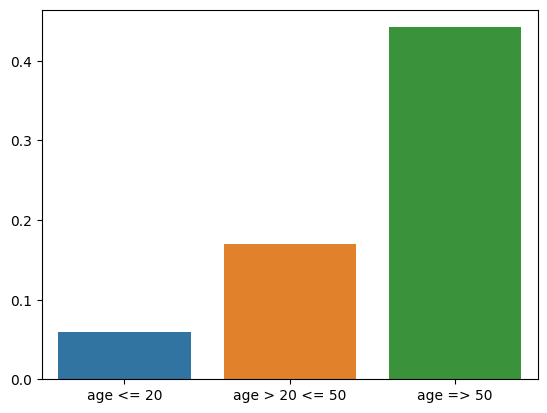

In [68]:
sns.barplot(age)

In [69]:
tenure = determine_effect(df=df_full_train, variable='tenure',min_cut=1, max_cut=5)
tenure

,tenure <= 1,tenure > 1 <= 5,tenure => 5
0,0.221145,0.201105,0.198448


<Axes: >

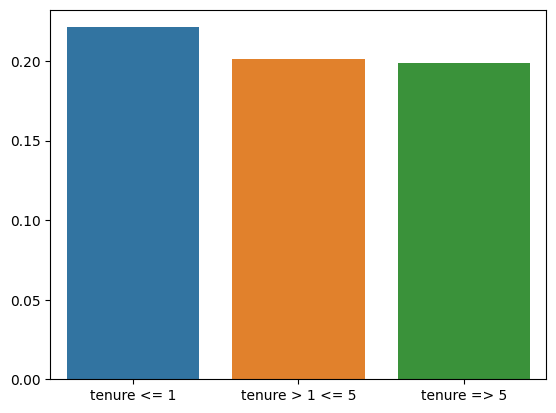

In [70]:
sns.barplot(tenure)

In [71]:
balance = determine_effect(df=df_full_train, variable='balance',min_cut=5000, max_cut=200000)
balance

,balance <= 5000,balance > 5000 <= 200000,balance => 200000
0,0.13718,0.238133,0.551724


<Axes: >

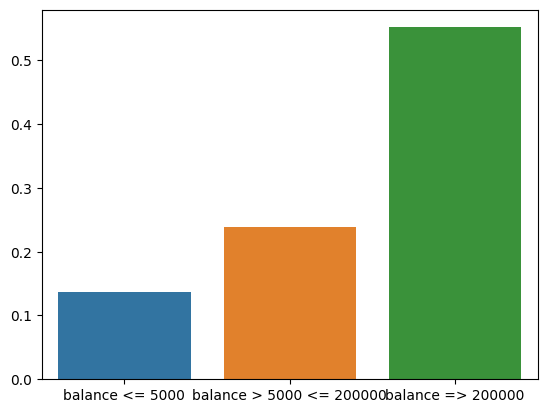

In [72]:
sns.barplot(balance)

### One-hot encoding 
Perform one-hot encoding to handle categoricalvariable

In [73]:
## First do the traning dataset (df_train)
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dicts)
X_train = dv.transform(train_dicts)

In [74]:
dv.feature_names_

['active_member',
 'age',
 'balance',
 'country=France',
 'country=Germany',
 'country=Spain',
 'credit_card',
 'credit_score',
 'estimated_salary',
 'gender=Female',
 'gender=Male',
 'products_number',
 'tenure']

In [75]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

### Train the model using scikit-learn

- Train the model using scikit-learn using the training dataset
- Check performance in validation
- Check the accuracies


In [77]:
logictic_model = LogisticRegression(max_iter=1000)
logictic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [111]:
## Predict churn in the validation dataset
y_pred = logictic_model.predict_proba(X_val)[:,1]
## Check the accuracy
churn_decision = y_pred > 0.6 ## Churn thershole set to 0.5
round((churn_decision == y_val).mean(),2)

0.8

In [112]:
### Examine different max_iter values: From code below max_iter of 1000 is used
for value in range(100, 1001, 100):
    logictic_model = LogisticRegression(max_iter=value)
    logictic_model.fit(X_train, y_train)

    y_pred = logictic_model.predict_proba(X_val)[:,1]
    ## Check the accuracy
    churn_decision = y_pred > 0.6 ## Churn thershole set to 0.5
    print('%.f accuracy: %.2f'  %(value, round((churn_decision == y_val).mean(),2)))

100 accuracy: 0.78
200 accuracy: 0.80
300 accuracy: 0.79
400 accuracy: 0.79
500 accuracy: 0.79
600 accuracy: 0.79
700 accuracy: 0.79
800 accuracy: 0.80
900 accuracy: 0.80
1000 accuracy: 0.80


In [113]:
logictic_model = LogisticRegression(max_iter=1000)
logictic_model.fit(X_train, y_train) 

LogisticRegression(max_iter=1000)

#### Evaluate the different cut off values
The 0.5 value for the threshold is arbitrary. So in this section diffferent values between 0.1 to 0.9 are explore to get the best cut off value

between 0.5 and 0.6 is about the best threshold to use. So I will use 0.6 as the threshold

In [114]:
cut_off = np.linspace(0,1,21)
scores = []
for value in cut_off:
    score = accuracy_score(y_val, y_pred >= value)
    print('%.2f %.3f' % (value, score))
    scores.append(score)
    

0.00 0.225
0.05 0.326
0.10 0.482
0.15 0.600
0.20 0.682
0.25 0.752
0.30 0.775
0.35 0.787
0.40 0.794
0.45 0.795
0.50 0.801
0.55 0.791
0.60 0.796
0.65 0.790
0.70 0.791
0.75 0.784
0.80 0.776
0.85 0.775
0.90 0.775
0.95 0.775
1.00 0.775


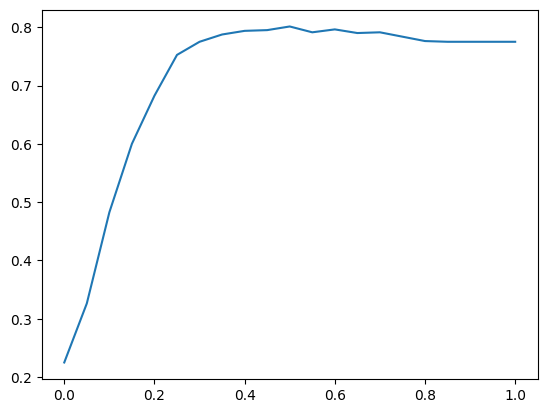

In [115]:
## Plot the threshold
plt.plot(cut_off,scores)

###  Evaluation of model using different matrices

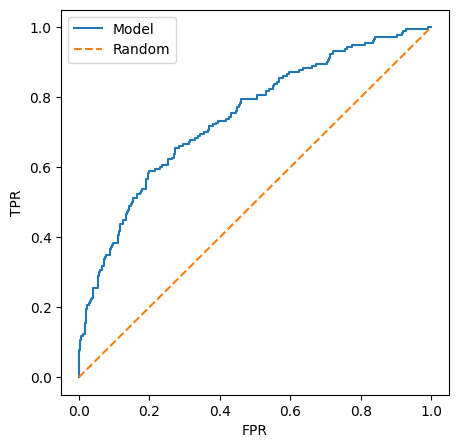

In [116]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
 
plt.figure(figsize=(5,5))
 
plt.plot(fpr, tpr, label='Model')
plt.plot([0,1], [0,1], label='Random', linestyle='--')
 
plt.xlabel('FPR')
plt.ylabel('TPR')
 
plt.legend()

### Parameter tuning 
The section below does the parameter tuning of the model to select the best paramaters

In [117]:
##### Define the functions to use for tuning the model

In [118]:
def train(df_train, y_train, C=1, max_iter=1000):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(C=C, max_iter=max_iter)
    model.fit(X_train, y_train)
 
    return dv, model


def predict(df, dv, model):
     dicts = df[categorical + numerical].to_dict(orient='records')
 
     X = dv.fit_transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
 
     return y_pred

In [119]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.churn.values
    y_val = df_val.churn.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

10it [00:05,  1.87it/s]


In [120]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.749 +- 0.016


In [121]:
from sklearn.model_selection import KFold
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
 
for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
     
    scores = []
 
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
 
        y_train = df_train.churn.values
        y_val = df_val.churn.values
 
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))


C=0.001 0.752 +- 0.012
C=0.01 0.752 +- 0.012
C=0.1 0.751 +- 0.013
C=0.5 0.751 +- 0.015
C=1 0.749 +- 0.016
C=5 0.751 +- 0.014
C=10 0.751 +- 0.013


In [122]:
## From above I use C=0.01 and max_iter=1000 for the final model
dv, model = train(df_full_train, df_full_train.churn.values, C=0.01, max_iter=1000)
y_pred = predict(df_test, dv, model)
 
auc = roc_auc_score(y_test, y_pred)
auc

0.7729633993386797